# NBA Player Selfishness Analysis

This notebook analyzes player selfishness in the NBA using multiple metrics that combine possession usage and playmaking tendencies.

## Overview

We identify "selfish" players as those who:
1. **Use lots of possessions** (high usage rate)
2. **Rarely create for teammates** (low assist percentage)
3. **Focus on shooting** rather than overall offensive facilitation

This analysis is grounded in basketball analytics literature, particularly Dean Oliver's possession-based frameworks from *Basketball on Paper* (2004).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.dpi'] = 100

## Load Data

First, we'll load the data generated by `build_leaderboard.py`. If you haven't generated it yet, run:

```bash
uv run python3 ballhog/build_leaderboard.py --seasons 2023-24
```

In [2]:
# Load the leaderboard data
df = pd.read_csv('ballhog_metrics.csv')

print(f"Dataset: {len(df)} player-seasons")
print(f"Seasons: {sorted(df['SEASON'].unique())}")
print(f"\nColumns: {df.columns.tolist()}")

Dataset: 572 player-seasons
Seasons: ['2023-24']

Columns: ['SEASON', 'PLAYER_ID', 'PLAYER_NAME', 'TEAM_ID', 'TEAM_ABBREVIATION', 'GP', 'MIN', 'FGA', 'FTA', 'TOV', 'AST_PCT', 'TEAM_NAME', 'GP_TEAM', 'FGA_TEAM', 'FTA_TEAM', 'TOV_TEAM', 'PLAYER_POSSESSIONS', 'TEAM_POSSESSIONS', 'USG_PCT', 'SELF_CREATION_INDEX', 'AST_TO_USG_RATIO', 'SHOT_CREATION_LOAD', 'SELFISHNESS_SCORE', 'KOBE_QUOTIENT', 'TEAM_RANK', 'LEAGUE_RANK']


## Understanding the Metrics

### 1. Standard Usage Rate (USG%)

$$\text{USG%} = \frac{FGA + 0.44 \times FTA + TOV}{\text{Team FGA} + 0.44 \times \text{Team FTA} + \text{Team TOV}}$$

- Measures what percentage of team possessions a player uses
- **0.44 coefficient**: Proportion of possession-ending free throws (from Oliver, 2004)
- **Turnovers included**: Represent possessions ending without shots

### 2. Self-Creation Index

$$\text{Self-Creation Index} = \text{USG%} \times \left(1 - \frac{\text{AST%}}{100}\right)$$

- Usage rate adjusted down by assist percentage
- High-usage players with low assists rank highest
- Measures possession usage specifically for self-scoring

### 3. Selfishness Score (Composite)

$$\text{Selfishness Score} = (\text{USG%} \times 100) \times 0.4 + \left(1 - \frac{\text{AST%}}{100}\right) \times 100 \times 0.4 + (\text{Shot Load} \times 100) \times 0.2$$

Combines:
- **40% Usage Rate**: How much they dominate possessions
- **40% Low Assists**: How little they create for teammates
- **20% Shot Creation**: How shot-heavy their usage is

## Top 20 Most Selfish Players (2023-24 Season)

In [3]:
# Filter to 2023-24 season and minimum games played
df_2024 = df[df['SEASON'] == '2023-24'].copy()
df_2024 = df_2024[df_2024['GP'] >= 20]  # At least 20 games played

# Display top 20 most selfish players
top_20 = df_2024.nlargest(20, 'SELFISHNESS_SCORE')[[
    'PLAYER_NAME', 'TEAM_ABBREVIATION', 'GP', 'MIN',
    'USG_PCT', 'AST_PCT', 'SELFISHNESS_SCORE', 'SELF_CREATION_INDEX',
    'AST_TO_USG_RATIO', 'LEAGUE_RANK'
]].copy()

# Format percentages for display
top_20['USG_PCT'] = (top_20['USG_PCT'] * 100).round(1)
top_20['AST_PCT'] = top_20['AST_PCT'].round(1)
top_20['SELFISHNESS_SCORE'] = top_20['SELFISHNESS_SCORE'].round(2)
top_20['SELF_CREATION_INDEX'] = top_20['SELF_CREATION_INDEX'].round(4)
top_20['AST_TO_USG_RATIO'] = top_20['AST_TO_USG_RATIO'].round(4)

print("Top 20 Most Selfish Players (2023-24 Season)")
print("=" * 120)
print(top_20.to_string(index=False))

Top 20 Most Selfish Players (2023-24 Season)
            PLAYER_NAME TEAM_ABBREVIATION  GP         MIN  USG_PCT  AST_PCT  SELFISHNESS_SCORE  SELF_CREATION_INDEX  AST_TO_USG_RATIO  LEAGUE_RANK
          Jalen Brunson               NYK  77 2726.303333     22.4      0.3              64.91               0.2238            0.0140            1
            Luka Dončić               DAL  70 2624.040000     24.0      0.4              64.42               0.2385            0.0179            2
        Anthony Edwards               MIN  79 2770.383333     22.6      0.2              64.34               0.2250            0.0107            3
           De'Aaron Fox               SAC  74 2658.763333     20.8      0.2              64.27               0.2073            0.0117            4
           Tyrese Maxey               PHI  70 2625.806667     18.6      0.3              64.00               0.1851            0.0138            5
        Dejounte Murray               ATL  78 2783.343333     18.7      0

## Visualization: Selfishness Landscape

Let's visualize the relationship between usage rate and assist percentage to see where "selfish" players cluster.

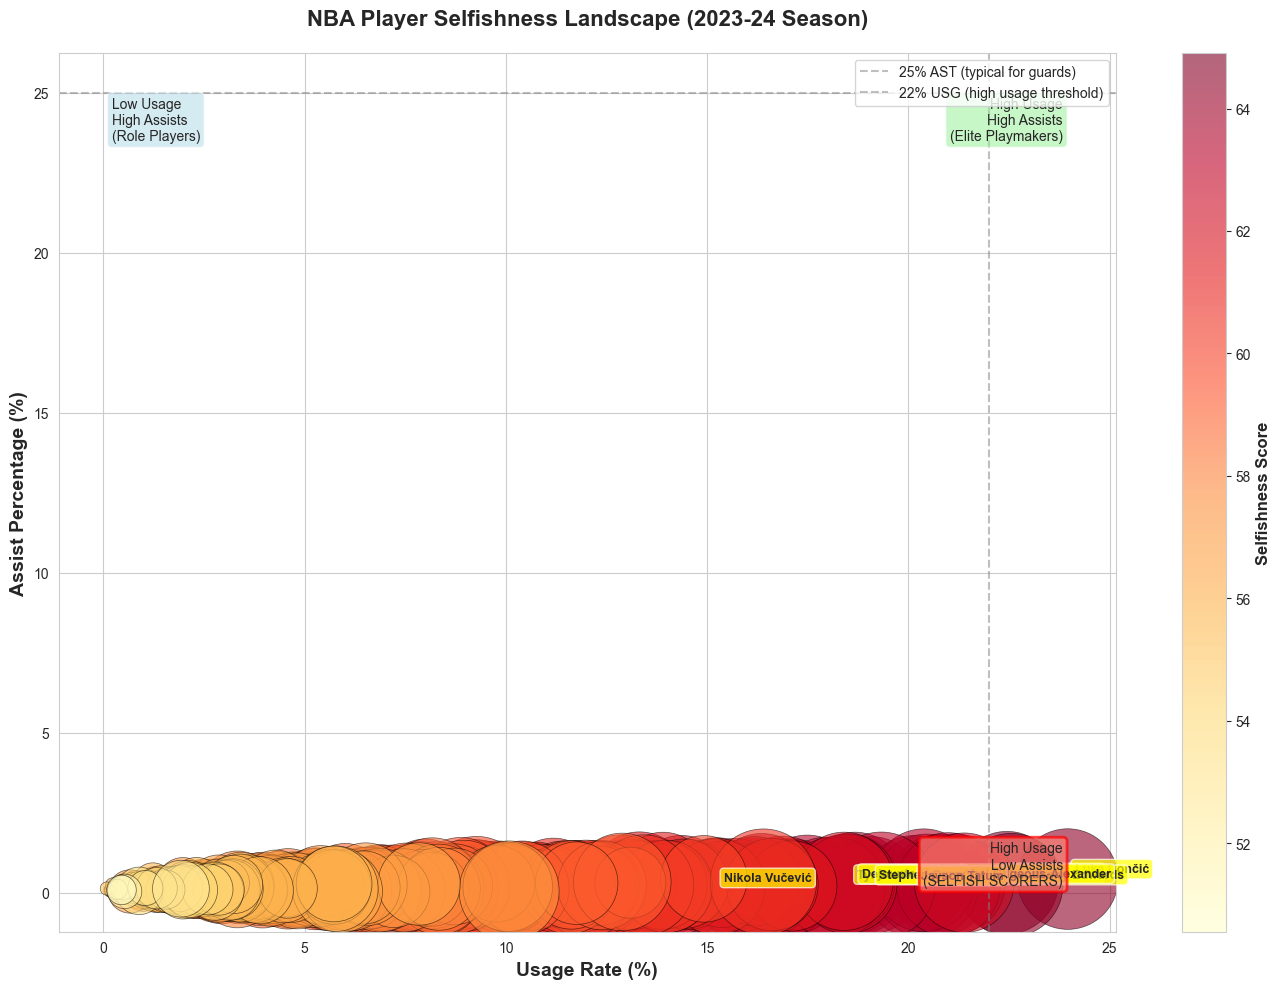


Note: Bubble size represents minutes played. Top 10 most selfish players are labeled.


In [4]:
# Create scatter plot
fig, ax = plt.subplots(figsize=(14, 10))

# Filter to players with meaningful minutes
df_viz = df_2024[df_2024['MIN'] >= 15].copy()

# Create scatter with color based on selfishness score
scatter = ax.scatter(
    df_viz['USG_PCT'] * 100,
    df_viz['AST_PCT'],
    c=df_viz['SELFISHNESS_SCORE'],
    s=df_viz['MIN'] * 2,  # Size by minutes played
    alpha=0.6,
    cmap='YlOrRd',
    edgecolors='black',
    linewidth=0.5
)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Selfishness Score', fontsize=12, fontweight='bold')

# Label top 10 most selfish players
top_10 = df_viz.nlargest(10, 'SELFISHNESS_SCORE')
for _, player in top_10.iterrows():
    ax.annotate(
        player['PLAYER_NAME'],
        (player['USG_PCT'] * 100, player['AST_PCT']),
        xytext=(5, 5),
        textcoords='offset points',
        fontsize=9,
        fontweight='bold',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7)
    )

# Add reference lines
ax.axhline(y=25, color='gray', linestyle='--', alpha=0.5, label='25% AST (typical for guards)')
ax.axvline(x=22, color='gray', linestyle='--', alpha=0.5, label='22% USG (high usage threshold)')

# Labels and title
ax.set_xlabel('Usage Rate (%)', fontsize=14, fontweight='bold')
ax.set_ylabel('Assist Percentage (%)', fontsize=14, fontweight='bold')
ax.set_title('NBA Player Selfishness Landscape (2023-24 Season)', fontsize=16, fontweight='bold', pad=20)
ax.legend(loc='upper right', fontsize=10)

# Add text annotations for quadrants
ax.text(0.05, 0.95, 'Low Usage\nHigh Assists\n(Role Players)', 
        transform=ax.transAxes, fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))
ax.text(0.95, 0.95, 'High Usage\nHigh Assists\n(Elite Playmakers)', 
        transform=ax.transAxes, fontsize=10, verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))
ax.text(0.95, 0.05, 'High Usage\nLow Assists\n(SELFISH SCORERS)', 
        transform=ax.transAxes, fontsize=10, verticalalignment='bottom', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='salmon', alpha=0.7, edgecolor='red', linewidth=2))

plt.tight_layout()
plt.savefig('selfishness_landscape_2024.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nNote: Bubble size represents minutes played. Top 10 most selfish players are labeled.")

## Comparison: Different Metrics

Let's compare how different metrics rank players differently.

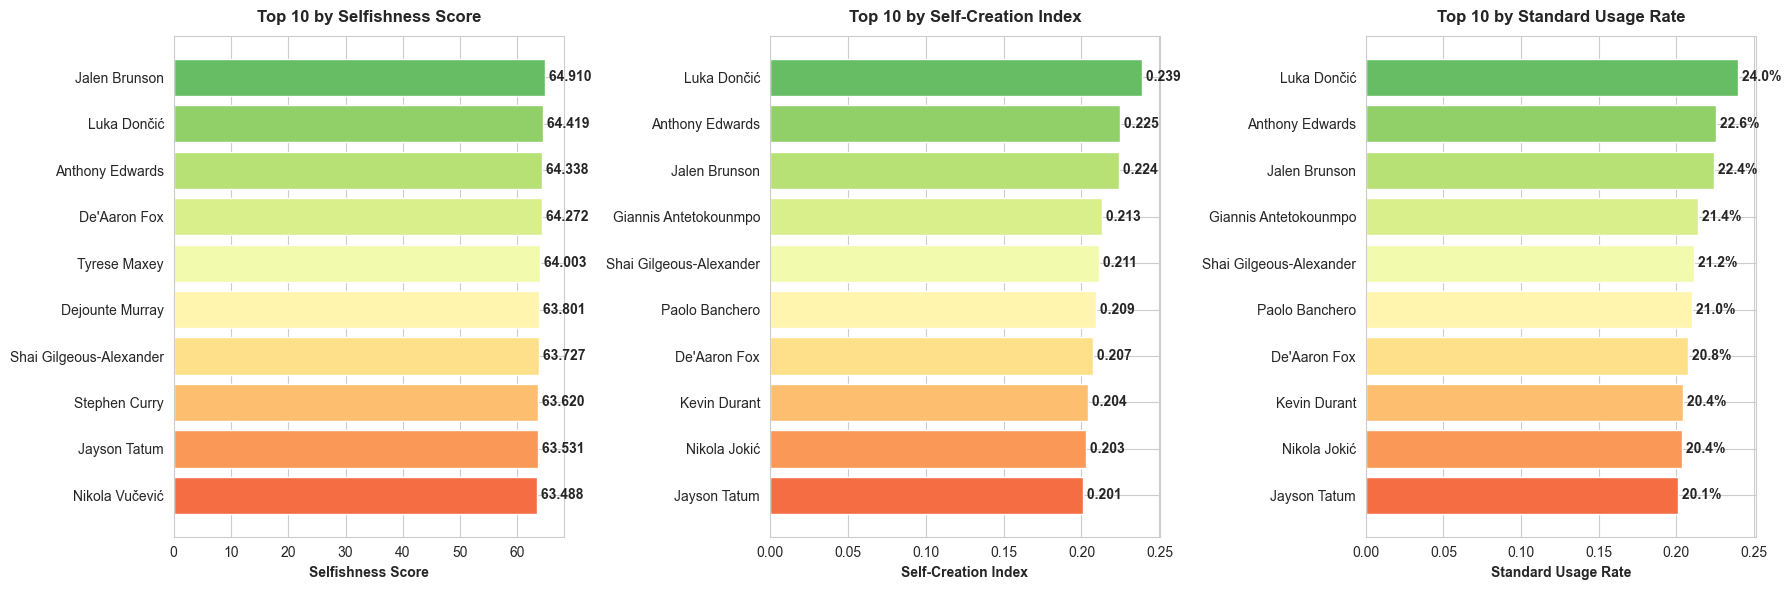

In [5]:
# Compare top 10 by different metrics
metrics = [
    ('SELFISHNESS_SCORE', 'Selfishness Score'),
    ('SELF_CREATION_INDEX', 'Self-Creation Index'),
    ('USG_PCT', 'Standard Usage Rate')
]

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for idx, (metric, title) in enumerate(metrics):
    top_10_metric = df_2024[df_2024['MIN'] >= 20].nlargest(10, metric)
    
    axes[idx].barh(
        range(10),
        top_10_metric[metric],
        color=plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, 10))
    )
    axes[idx].set_yticks(range(10))
    axes[idx].set_yticklabels(top_10_metric['PLAYER_NAME'])
    axes[idx].set_xlabel(title, fontweight='bold')
    axes[idx].set_title(f'Top 10 by {title}', fontweight='bold', pad=10)
    axes[idx].invert_yaxis()
    
    # Add values on bars
    for i, v in enumerate(top_10_metric[metric]):
        if metric == 'USG_PCT':
            axes[idx].text(v, i, f' {v*100:.1f}%', va='center', fontweight='bold')
        else:
            axes[idx].text(v, i, f' {v:.3f}', va='center', fontweight='bold')

plt.tight_layout()
plt.savefig('metric_comparison_2024.png', dpi=300, bbox_inches='tight')
plt.show()

## Distribution Analysis

Let's examine the distribution of selfishness across the league.

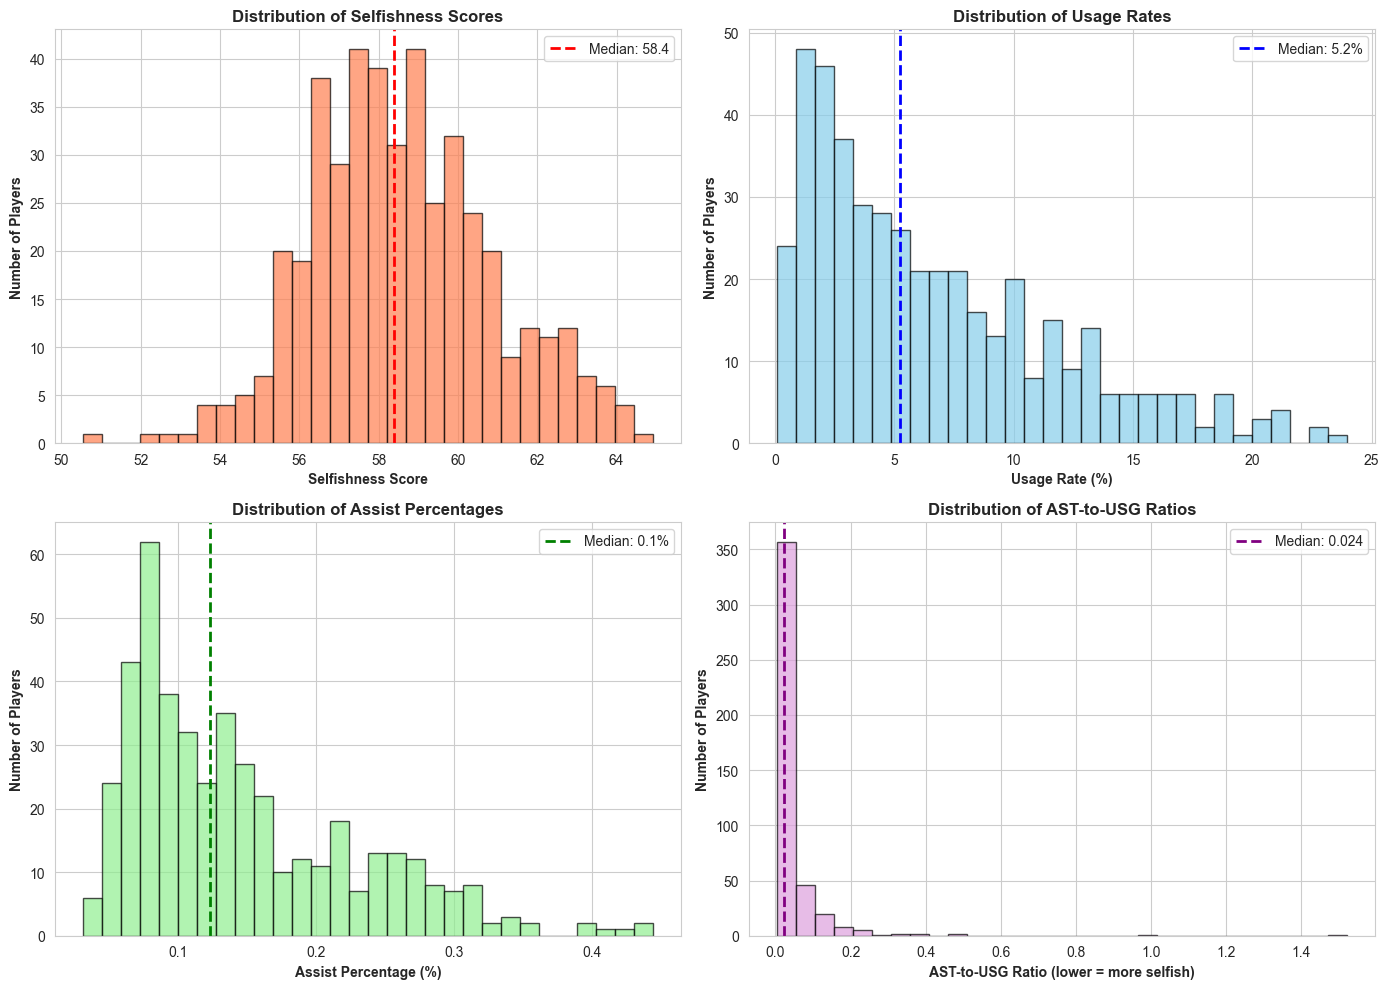

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Filter to meaningful players
df_qualified = df_2024[df_2024['MIN'] >= 15].copy()

# 1. Selfishness Score distribution
axes[0, 0].hist(df_qualified['SELFISHNESS_SCORE'], bins=30, color='coral', edgecolor='black', alpha=0.7)
axes[0, 0].axvline(df_qualified['SELFISHNESS_SCORE'].median(), color='red', linestyle='--', linewidth=2, label=f'Median: {df_qualified["SELFISHNESS_SCORE"].median():.1f}')
axes[0, 0].set_xlabel('Selfishness Score', fontweight='bold')
axes[0, 0].set_ylabel('Number of Players', fontweight='bold')
axes[0, 0].set_title('Distribution of Selfishness Scores', fontweight='bold')
axes[0, 0].legend()

# 2. Usage Rate distribution
axes[0, 1].hist(df_qualified['USG_PCT'] * 100, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
axes[0, 1].axvline((df_qualified['USG_PCT'] * 100).median(), color='blue', linestyle='--', linewidth=2, label=f'Median: {(df_qualified["USG_PCT"] * 100).median():.1f}%')
axes[0, 1].set_xlabel('Usage Rate (%)', fontweight='bold')
axes[0, 1].set_ylabel('Number of Players', fontweight='bold')
axes[0, 1].set_title('Distribution of Usage Rates', fontweight='bold')
axes[0, 1].legend()

# 3. Assist Percentage distribution
axes[1, 0].hist(df_qualified['AST_PCT'], bins=30, color='lightgreen', edgecolor='black', alpha=0.7)
axes[1, 0].axvline(df_qualified['AST_PCT'].median(), color='green', linestyle='--', linewidth=2, label=f'Median: {df_qualified["AST_PCT"].median():.1f}%')
axes[1, 0].set_xlabel('Assist Percentage (%)', fontweight='bold')
axes[1, 0].set_ylabel('Number of Players', fontweight='bold')
axes[1, 0].set_title('Distribution of Assist Percentages', fontweight='bold')
axes[1, 0].legend()

# 4. AST-to-USG Ratio distribution
axes[1, 1].hist(df_qualified['AST_TO_USG_RATIO'], bins=30, color='plum', edgecolor='black', alpha=0.7)
axes[1, 1].axvline(df_qualified['AST_TO_USG_RATIO'].median(), color='purple', linestyle='--', linewidth=2, label=f'Median: {df_qualified["AST_TO_USG_RATIO"].median():.3f}')
axes[1, 1].set_xlabel('AST-to-USG Ratio (lower = more selfish)', fontweight='bold')
axes[1, 1].set_ylabel('Number of Players', fontweight='bold')
axes[1, 1].set_title('Distribution of AST-to-USG Ratios', fontweight='bold')
axes[1, 1].legend()

plt.tight_layout()
plt.savefig('distribution_analysis_2024.png', dpi=300, bbox_inches='tight')
plt.show()

## Summary Statistics

In [7]:
print("League-Wide Summary Statistics (2023-24, Min 15 MPG)")
print("=" * 80)

summary_stats = df_qualified[[
    'SELFISHNESS_SCORE', 'USG_PCT', 'AST_PCT', 
    'SELF_CREATION_INDEX', 'AST_TO_USG_RATIO'
]].describe()

# Format for better display
summary_stats.loc['mean', 'USG_PCT'] *= 100
summary_stats.loc['std', 'USG_PCT'] *= 100
summary_stats.loc['min', 'USG_PCT'] *= 100
summary_stats.loc['25%', 'USG_PCT'] *= 100
summary_stats.loc['50%', 'USG_PCT'] *= 100
summary_stats.loc['75%', 'USG_PCT'] *= 100
summary_stats.loc['max', 'USG_PCT'] *= 100

print(summary_stats.to_string())

print("\n" + "=" * 80)
print(f"Most Selfish Player: {df_qualified.nlargest(1, 'SELFISHNESS_SCORE')['PLAYER_NAME'].values[0]}")
print(f"Least Selfish Player: {df_qualified.nsmallest(1, 'SELFISHNESS_SCORE')['PLAYER_NAME'].values[0]}")
print(f"Highest Usage: {df_qualified.nlargest(1, 'USG_PCT')['PLAYER_NAME'].values[0]}")
print(f"Highest Assist%: {df_qualified.nlargest(1, 'AST_PCT')['PLAYER_NAME'].values[0]}")

League-Wide Summary Statistics (2023-24, Min 15 MPG)
       SELFISHNESS_SCORE     USG_PCT     AST_PCT  SELF_CREATION_INDEX  AST_TO_USG_RATIO
count         445.000000  445.000000  445.000000           445.000000        445.000000
mean           58.567027    6.598264    0.145272             0.065867          0.048933
std             2.323244    5.184970    0.081442             0.051723          0.101400
min            50.552601    0.087488    0.031000             0.000874          0.004740
25%            56.910306    2.322584    0.082000             0.023203          0.014307
50%            58.391594    5.237828    0.123000             0.052342          0.024049
75%            60.006977    9.813836    0.196000             0.097975          0.046176
max            64.910253   23.956959    0.444000             0.238544          1.520217

Most Selfish Player: Jalen Brunson
Least Selfish Player: Ibou Badji
Highest Usage: Luka Dončić
Highest Assist%: Tyrese Haliburton


## Key Takeaways

1. **Selfishness is multi-dimensional**: Pure usage rate doesn't capture selfishness - we need to account for playmaking (assists)

2. **Multiple paths to selfishness**:
   - High usage + low assists (e.g., Anthony Edwards)
   - Moderate usage + very low assists (e.g., Nikola Vučević)
   
3. **Elite playmakers vs. selfish scorers**: Players like Luka Dončić have high usage but also high assists, distinguishing them from pure selfish scorers

4. **Metrics tell different stories**:
   - **Selfishness Score**: Best composite measure for identifying selfish play
   - **Self-Creation Index**: Emphasizes self-scoring over team facilitation
   - **Standard Usage**: Raw possession dominance without playmaking context

## References

- Oliver, D. (2004). *Basketball on Paper: Rules and Tools for Performance Analysis*. Potomac Books.
- Kubatko, J., Oliver, D., Pelton, K., & Rosenbaum, D. (2007). A Starting Point for Analyzing Basketball Statistics. *Journal of Quantitative Analysis in Sports*, 3(3).
- Cleaning the Glass analytics guidelines: https://cleaningtheglass.com/stats/guide/player_offensive_overview

See `README.md` for complete references and methodology details.